In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch as th

import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['text.latex.preamble'] = r"\usepackage{lmodern} \usepackage{amsmath}"
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
        #   'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

In [3]:

class Bandit():
  ''' Class which takes the no of action, mean and variance as input '''
  def __init__(self,n_action=10,mean=0,variance=1, name=None):
    self.n_action = n_action
    self.mean = mean 
    self.center_variance = variance
    self.action_variance = variance
    if name == 'near zero':
      self.q_star = np.arange(-5,-2, (3/self.n_action)) # creating a linear space of q_star
    elif name == 'near one':
      self.q_star = np.arange(1,5, (4/self.n_action))
    elif name == 'evenly spaced':
      self.q_star = np.arange(-3,3, (6/self.n_action))
    else:
      self.q_star = np.random.normal(self.mean,self.center_variance,self.n_action)
    self.s_q_star = self.compute_sigmoid_q_star()
  
  def compute_sigmoid_q_star(self):
    num_samples = int(1e7)
    s_qstar = np.zeros(self.n_action)
    for i in range(len(self.q_star)):
      real_rewards = np.random.normal(self.q_star[i], self.action_variance , num_samples)
      sigmoid_rewards = 1/(1+np.exp(-real_rewards))
      s_qstar[i] = np.mean(sigmoid_rewards)
    return s_qstar

  def return_no_actions(self):
    return self.n_action
  
  def optimal_action(self):
    return np.argmax(self.q_star)
  
  def pull_numpy(self,action):
    # print(self.q_star[action])
    s = np.random.normal(self.q_star[action], 1 , 1)
    # print(s)
    sigmoid_s = 1/(1+np.exp(-s))
    assert sigmoid_s <= 1 and sigmoid_s >= 0
    return sigmoid_s[0]

  def pull(self,action):
    action_th = th.tensor(self.q_star[action])
    variance_th = th.tensor(self.action_variance)
    std = variance_th.repeat(action_th.size())**0.5
    s = th.normal(action_th, std)
    sigmoid_s = 1/(1+th.exp(-s))
    assert sigmoid_s.all() <= 1 and sigmoid_s.all() >= 0
    return sigmoid_s
  
  def return_exp_optimal_reawrd(self):
    return np.max(self.q_star)

In [4]:
def batched_cross_learning(runs,epochs,bandit,batch_size):
    
    optimal_actions = np.zeros((runs,epochs))
    reward_overall = np.zeros((runs,epochs))

    for i in range(epochs):
        policy = np.ones(bandit.return_no_actions())/bandit.return_no_actions()
        for j in range(runs):
            
            action = np.random.choice(bandit.return_no_actions(),batch_size,p=policy)
            reward = bandit.pull(action)
            action_mask = np.zeros((batch_size,bandit.return_no_actions()))
            action_mask[np.arange(batch_size),action] = 1
            cases = action_mask - np.broadcast_to(policy,(batch_size,bandit.return_no_actions()))
            del_policy = np.einsum('ij,i->ij',cases,reward)
            policy = policy + np.mean(del_policy,axis=0)
            reward_overall[j,i] = np.mean(reward.numpy())
            # count number of actions equal to optimal action
            optimal_actions[j,i] =  np.sum(action == bandit.optimal_action())/batch_size

    return reward_overall, optimal_actions


In [5]:
def batched_maynard_learning(runs,epochs,bandit,batch_size):
        
        optimal_actions = np.zeros((runs,epochs))
        reward_overall = np.zeros((runs,epochs))
    
        for i in range(epochs):
            policy = np.ones(bandit.return_no_actions())/bandit.return_no_actions()
            mean_reward = 0
            for j in range(runs):
                
                action = np.random.choice(bandit.return_no_actions(),batch_size,p=policy)
                reward = bandit.pull(action)
                action_mask = np.zeros((batch_size,bandit.return_no_actions()))
                action_mask[np.arange(batch_size),action] = 1
                # if j == 0:
                reward_mean = np.mean(reward.numpy())
                # else:
                #     reward_mean = (1-alpha_baseline)*reward_mean + alpha_baseline*np.mean(reward.numpy())

                cases = action_mask - np.broadcast_to(policy,(batch_size,bandit.return_no_actions()))
                del_policy = np.einsum('ij,i->ij',cases,reward/reward_mean)
                policy = policy + np.mean(del_policy,axis=0)
                reward_overall[j,i] = reward_mean
                optimal_actions[j,i] =  np.sum(action == bandit.optimal_action())/batch_size

                policy = np.clip(policy,0,1)
    
        return reward_overall, optimal_actions
    

In [6]:
def cross_learning(runs,epochs,alpha,bandit):
    
    optimal_actions = np.zeros((runs,epochs))
    reward_overall = th.zeros(runs,epochs)
    policy = th.ones(epochs,bandit.return_no_actions())*1/bandit.return_no_actions()

    for j in range(runs):
        action = th.distributions.Categorical(policy).sample()
        
        reward = bandit.pull(action)
        reward_overall[j,:] = reward
        optimal_actions[j,:] = (action.numpy() == bandit.optimal_action())
        mask = th.zeros(epochs,bandit.return_no_actions())
        index = th.arange(epochs)
        mask[index,action] = 1
        policy = policy + alpha*th.einsum('ij,i->ij',mask - policy, reward)
    
    return reward_overall, optimal_actions



In [7]:
def taylor_replicator_dynamics(alpha,bandit,runs):
    dt = alpha
    time = np.arange(0,alpha*runs,dt)
    mean_reward_trd = np.zeros(len(time))
    s_qstar = bandit.s_q_star
    x = np.ones(bandit.return_no_actions())*1/bandit.return_no_actions()

    for i in range(len(time)):
        mean_reward_trd[i] = np.dot(x,s_qstar)
        dx = np.zeros(len(x))
        dx = x*(s_qstar - np.dot(s_qstar,x))
        x = x + dx*dt
        
    return mean_reward_trd

In [8]:
def maynard_cross_learning(runs,epochs,alpha,alpha_baseline,bandit):

    optimal_actions = np.zeros((runs,epochs))
    reward_overall = th.zeros(runs,epochs)
    policy = th.ones(epochs,bandit.return_no_actions())*1/bandit.return_no_actions()
    mean_reward = th.zeros(epochs)
    
    for j in range(runs):

        action = th.distributions.Categorical(policy).sample()
        reward = bandit.pull(action)

        reward_overall[j,:] = reward

        if j == 0:
            mean_reward = reward 
        else:
            mean_reward = alpha_baseline*reward + (1-alpha_baseline)*mean_reward
        

        optimal_actions[j,:] = (action.numpy() == bandit.optimal_action())
        mask = th.zeros(epochs,bandit.return_no_actions())
        index = th.arange(epochs)
        mask[index,action] = 1

        policy = policy + alpha*th.einsum('ij,i->ij',mask - policy, reward/mean_reward)

        # bound policy between 0 and 1, this only happens when alpha is large
        policy = th.clamp(policy,0,1)
    
    return reward_overall, optimal_actions

In [9]:
def maynard_replicator_dynamics(alpha,bandit,runs):
    dt = alpha
    time = np.arange(0,alpha*runs,dt)
    mean_reward_mrd = np.zeros(len(time))
    s_qstar = bandit.s_q_star
    x = np.ones(bandit.return_no_actions())*1/bandit.return_no_actions()


    for i in range(len(time)):
        mean_reward_mrd[i] = np.dot(x,s_qstar)
        dx = np.zeros(len(x))
        dx = x*(s_qstar - np.dot(s_qstar,x))/np.dot(x,s_qstar)
        x = x + dx*dt
        
    return mean_reward_mrd

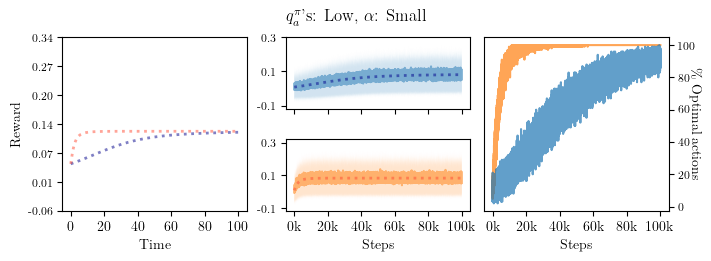

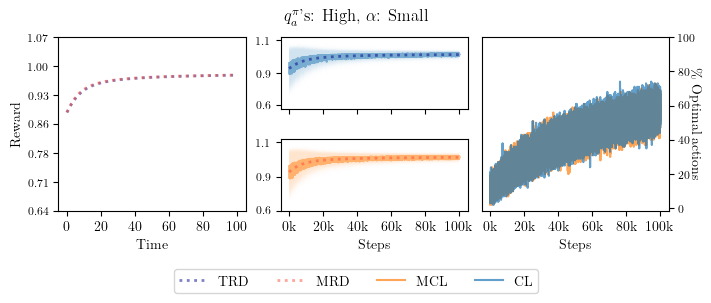

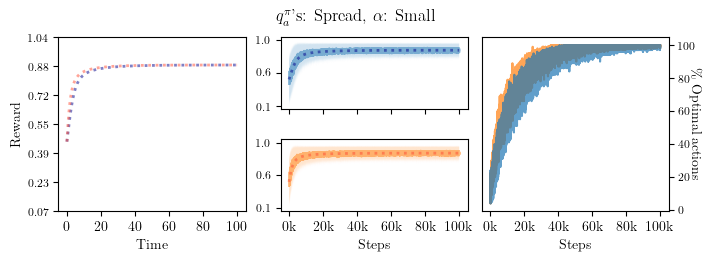

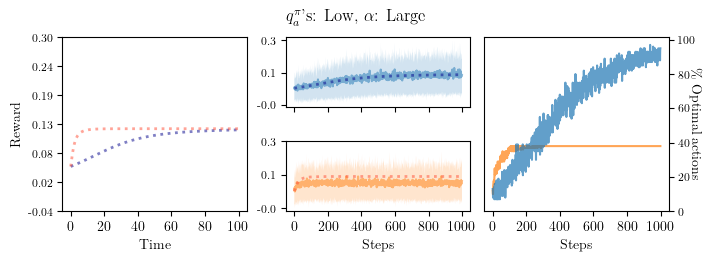

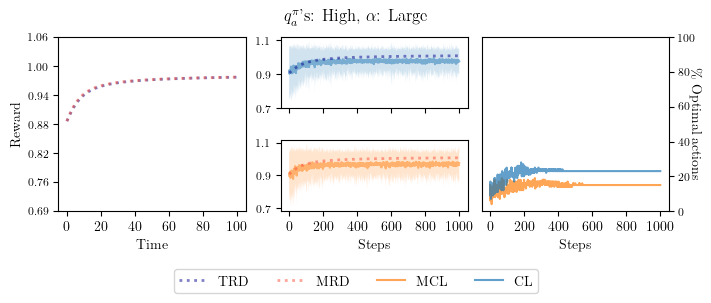

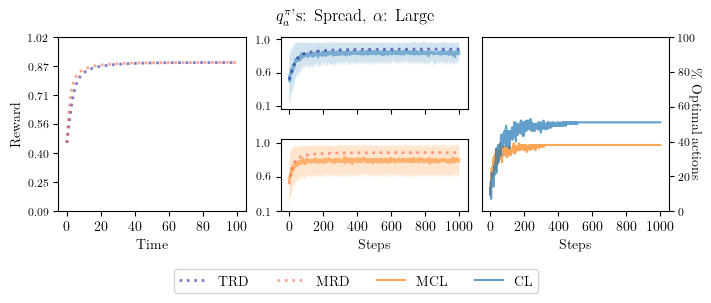

In [ ]:
for alpha in [0.001,0.1]:
        for name in ['near zero','near one','evenly spaced']:
        
                bandit = Bandit(n_action=10,mean=0,variance=1, name=name)
                # print(bandit.s_q_star)
                if alpha == 0.001:
                        runs = 100000
                        epochs = 100
                
                else:
                        runs = 1000
                        epochs = 100
                        
                alpha = alpha
                alpha_baseline = 0.01

                reward_overall_cl, optimal_actions_cl = cross_learning(runs,epochs,alpha,bandit)
                mean_reward_trd = taylor_replicator_dynamics(alpha,bandit,runs)
                reward_overall_mcl, optimal_actions_mcl = maynard_cross_learning(runs,epochs,alpha,alpha_baseline,bandit)
                mean_reward_mrd = maynard_replicator_dynamics(alpha,bandit,runs)

                #plot stuff
                plt.rcParams['figure.figsize'] = [7, 2.5]
                fig = plt.figure(constrained_layout=True)
                gs = fig.add_gridspec(2, 3)
                ax0 = fig.add_subplot(gs[:, 0])
                ax1 = fig.add_subplot(gs[0, 1])
                ax2 = fig.add_subplot(gs[1, 1])
                ax3 = fig.add_subplot(gs[:, 2])
                fontsize=10
                plt.rcParams.update({'font.size': fontsize})
                ax2.sharex(ax1)
                ax3.sharex(ax1)
                
                colors = ['#1f77b4', '#ff7f0e', '#ff4b33', '#00008b']
                lines_labels=[]

                max_cl = max(reward_overall_cl.numpy().mean(axis=1) + reward_overall_cl.numpy().std(axis=1))
                max_mcl = max(reward_overall_mcl.numpy().mean(axis=1) + reward_overall_mcl.numpy().std(axis=1))
                max_reward = max_cl if max_cl > max_mcl else max_mcl
                min_cl = min(reward_overall_cl.numpy().mean(axis=1) - reward_overall_cl.numpy().std(axis=1))
                min_mcl = min(reward_overall_mcl.numpy().mean(axis=1) - reward_overall_mcl.numpy().std(axis=1))
                min_reward = min_cl if min_cl < min_mcl else min_mcl


                reward_steps = (max_reward - min_reward)/6
                # print(min_reward,max_reward)
                # print(reward_steps)
                reward_ticks = [min_reward+i*reward_steps for i in range(7)]
                # print(reward_ticks)

                step_x = runs/5


                ax0.plot(range(runs),mean_reward_trd, label='TRD', color=colors[3], linestyle='dotted', linewidth=2, alpha=0.5)
                ax0.plot(range(runs),mean_reward_mrd, label='MRD', color=colors[2], linestyle='dotted', linewidth=2, alpha=0.5)
                ax0.set_yticks(reward_ticks)
                ax0.set_yticklabels([f'{i:.2f}' for i in reward_ticks], fontsize=8)
                ax0.set_ylim(reward_ticks[0],reward_ticks[-1])
                ax0.set_ylabel('Reward', fontsize=fontsize)
                
                if alpha == 0.001:
                        ax0.set_xticks([i for i in np.arange(0,round(runs+step_x),step_x)])
                        ax0.set_xticklabels([f'{i/1000:.0f}' for i in np.arange(0,round(runs+step_x),step_x)], fontsize=fontsize)
                
                else:
                        ax0.set_xticks([i for i in np.arange(0,round(runs+step_x),step_x)])
                        ax0.set_xticklabels([f'{i/10:.0f}' for i in np.arange(0,round(runs+step_x),step_x)], fontsize=fontsize)


                if alpha == 0.001:
                        ax1.set_xticks([i for i in np.arange(0,round(runs+step_x),step_x)])
                        ax1.set_xticklabels([f'{i/1000:.0f}k' for i in np.arange(0,round(runs+step_x),step_x)], fontsize=fontsize)

                else:
                        ax1.set_xticks([i for i in np.arange(0,round(runs+step_x),step_x)])
                        ax1.set_xticklabels([f'{i:.0f}' for i in np.arange(0,round(runs+step_x),step_x)], fontsize=fontsize)


                ax1.plot(range(runs),reward_overall_cl.numpy().mean(axis=1), label='CL', color=colors[0], alpha=0.5)
                ax1.plot(range(runs),mean_reward_trd, label='TRD', color=colors[3], linestyle='dotted', alpha=0.5, linewidth=2)
                ax1.fill_between(range(runs),reward_overall_cl.numpy().mean(axis=1) - reward_overall_cl.numpy().std(axis=1),reward_overall_cl.numpy().mean(axis=1) + reward_overall_cl.numpy().std(axis=1),facecolor=colors[0], alpha=0.2)
                ax2.plot(range(runs),reward_overall_mcl.numpy().mean(axis=1), label='MCL', color=colors[1], alpha=0.5)
                ax2.plot(range(runs),mean_reward_mrd, label='MRD', color=colors[2], linestyle='dotted', alpha=0.5, linewidth=2)
                ax2.fill_between(range(runs),reward_overall_mcl.numpy().mean(axis=1) - reward_overall_mcl.numpy().std(axis=1),reward_overall_mcl.numpy().mean(axis=1) + reward_overall_mcl.numpy().std(axis=1),facecolor=colors[1], alpha=0.2)
                
                # show only three points in the y axis
                small_ticks = [reward_ticks[0],reward_ticks[int(7/2)],reward_ticks[-1]]
                ax1.set_yticks(small_ticks)
                ax1.set_yticklabels([f'{i:.1f}' for i in small_ticks], fontsize=8)
                ax2.set_yticks(small_ticks)
                ax2.set_yticklabels([f'{i:.1f}' for i in small_ticks], fontsize=8)

                ax1.tick_params(labelbottom=False)
                ax2.set_xlabel('Steps', fontsize=fontsize)



                ax3.plot(range(runs),optimal_actions_mcl.mean(axis=1)*100,label='MCL', color=colors[1], alpha=0.7)
                ax3.plot(range(runs),optimal_actions_cl.mean(axis=1)*100,label='CL', color=colors[0], alpha=0.7)
                ax3.yaxis.tick_right()
                ax3.yaxis.set_label_position("right")
                ax3.set_yticks([i for i in np.arange(0,120,20)])
                ax3.set_yticklabels([f'{i}' for i in np.arange(0,120,20)], fontsize=8)
                ax3.set_ylabel(r'$\%$ Optimal actions', fontsize=fontsize, rotation=270)
                ax0.set_xlabel('Time', fontsize=fontsize)
                ax3.set_xlabel('Steps', fontsize=fontsize)


                # set legend outside the plot
                
                lines_labels = [ax0.get_legend_handles_labels()]
                lines_labels.append(ax3.get_legend_handles_labels())
                lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

                if alpha == 0.001:
                        alpha_name = 'Small'
                else:
                        alpha_name = 'Large'

                if name == "evenly spaced":
                        title_name = 'Spread'
                        title = r"$q^{\pi}_a$'s: "+str(title_name)+ r", $\alpha$: " + str(alpha_name)

                elif name == "near zero":
                        title_name = 'Low'
                        title = r"$q^{\pi}_a$'s: "+str(title_name)+ r", $\alpha$: " + str(alpha_name)
                
                else:                
                        title_name = 'High'
                        title = r"$q^{\pi}_a$'s: "+str(title_name)+ r", $\alpha$: " + str(alpha_name)

                
                fig.suptitle(title, fontsize=12)
                if (title_name == 'High') or (title_name == 'Spread' and alpha_name == 'Large'):
                        # fig.text(0.5, -0.02, 'Runs', ha='center', va='center', fontsize=fontsize)
                        fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.03), ncol=4, fontsize=fontsize)
                
                plt.savefig(f"rl_streaming_scenario_{title_name}_alpha_{alpha_name}.pdf", bbox_inches='tight',dpi=900)



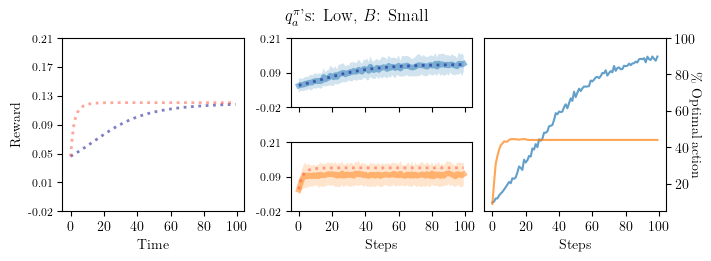

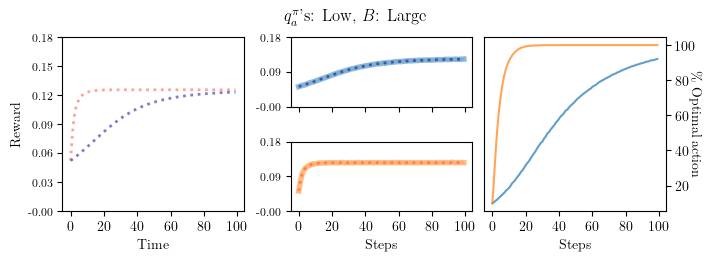

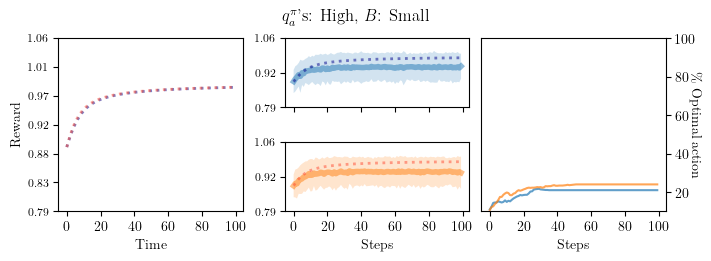

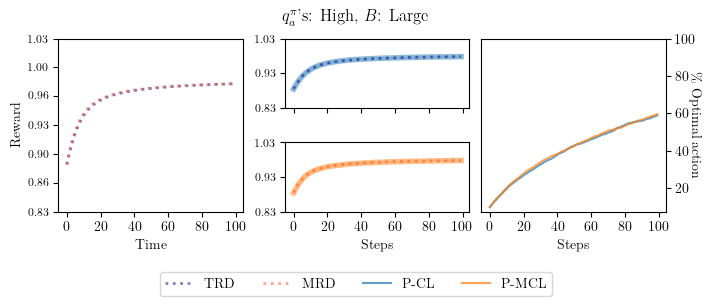

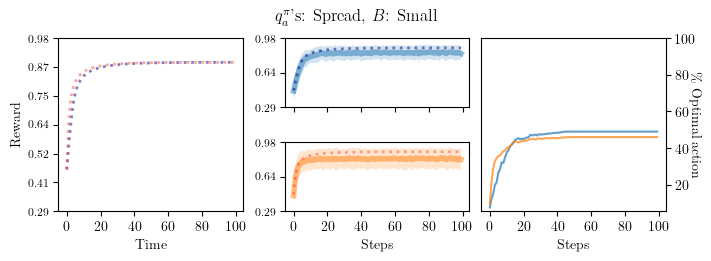

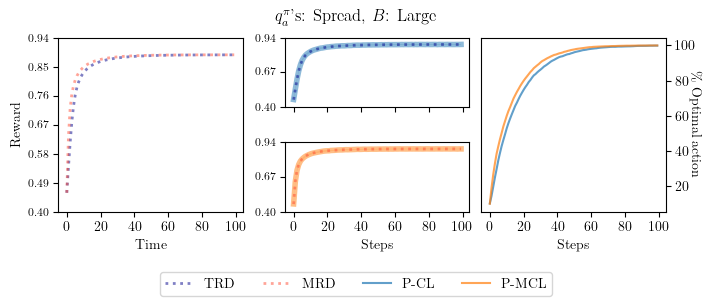

In [14]:
batch_sizes = [10, 1000]
runs = 100
epochs = 100


for name in ['near zero','near one','evenly spaced']:
    for batch_size in batch_sizes:
        bandit = Bandit(n_action=10, mean=0, variance=1, name=name)
        mean_rewards_bcl, optimal_action_bcl  = batched_cross_learning(runs, epochs, bandit, batch_size)
        mean_rewards_bmcl, optimal_action_bmcl  = batched_maynard_learning(runs, epochs, bandit, batch_size)
        mean_rewards_trd = taylor_replicator_dynamics(1, bandit, runs)
        mean_rewards_mrd = maynard_replicator_dynamics(1, bandit, runs)


        #plot stuff
        plt.rcParams['figure.figsize'] = [7, 2.5]
        fig = plt.figure(constrained_layout=True)
        gs = fig.add_gridspec(2, 3)
        ax0 = fig.add_subplot(gs[:, 0])
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[:, 2])
        fontsize=10
        plt.rcParams.update({'font.size': fontsize})
        ax2.sharex(ax1)
        ax3.sharex(ax1)


        # axs[2].sharex(axs[3])

        colors = ['#1f77b4', '#ff7f0e', '#ff4b33', '#00008b']
        lines_labels=[]

        max_bcl = max(mean_rewards_bcl.mean(axis=1) + mean_rewards_bcl.std(axis=1))
        max_bmcl = max(mean_rewards_bmcl.mean(axis=1) + mean_rewards_bmcl.std(axis=1))
        max_reward = max_bcl if max_bcl > max_bmcl else max_bmcl
        min_bcl = min(mean_rewards_bcl.mean(axis=1) - mean_rewards_bcl.std(axis=1))
        min_bmcl = min(mean_rewards_bmcl.mean(axis=1) - mean_rewards_bmcl.std(axis=1))
        min_reward = min_bcl  if min_bcl < min_bmcl else min_bmcl



        reward_steps = (max_reward  - min_reward)/6 + 0.1/6
        reward_ticks = [min_reward - 0.05 + i*reward_steps for i in range(7)]
        step_x = runs/5
        # reward_steps = (max_reward - min_reward)/6
        # # print(min_reward,max_reward)
        # # print(reward_steps)
        # reward_ticks = [min_reward+i*reward_steps for i in range(7)]
        # # print(reward_ticks)

        # step_x = runs/5


        ax0.plot(range(runs),mean_rewards_trd, label='TRD', color=colors[3], linestyle='dotted', linewidth=2, alpha=0.5)
        ax0.plot(range(runs),mean_rewards_mrd, label='MRD', color=colors[2], linestyle='dotted', linewidth=2, alpha=0.5)

        
        ax0.set_ylim(reward_ticks[0],reward_ticks[-1])
        ax0.set_yticks(reward_ticks)
        ax0.set_yticklabels([f'{i:.2f}' for i in reward_ticks], fontsize=8)
        ax0.set_xticks([i for i in np.arange(0,runs+step_x,step_x)])
        ax0.set_ylabel('Reward', fontsize=fontsize)
        
        ax0.set_xticklabels([f'{i:.0f}' for i in np.arange(0,runs+step_x,step_x)], fontsize=fontsize)
        ax0.set_xlabel('Time', fontsize=fontsize)


        # show only three points in the y axis
        small_ticks = [reward_ticks[0],reward_ticks[int(7/2)],reward_ticks[-1]]
        ax1.set_ylim(reward_ticks[0],reward_ticks[-1])
        ax2.set_ylim(reward_ticks[0],reward_ticks[-1])
        ax1.set_yticks(small_ticks)
        ax1.set_yticklabels([f'{i:.2f}' for i in small_ticks], fontsize=8)
        ax2.set_yticks(small_ticks)
        ax2.set_yticklabels([f'{i:.2f}' for i in small_ticks], fontsize=8)

        ax1.tick_params(labelbottom=False)
        ax2.set_xticks([i for i in np.arange(0,runs+step_x,step_x)])
        ax2.set_xticklabels([f'{i:.0f}' for i in np.arange(0,runs+step_x,step_x)], fontsize=fontsize)
        ax2.set_xlabel('Steps', fontsize=fontsize)
        
        ax1.plot(range(runs),mean_rewards_bcl.mean(axis=1), label='P-CL', color=colors[0], alpha=0.5, linewidth=4)
        ax1.plot(range(runs),mean_rewards_trd, label='TRD', color=colors[3], linestyle='dotted', linewidth=2, alpha=0.5)
        ax1.fill_between(range(runs),mean_rewards_bcl.mean(axis=1) - mean_rewards_bcl.std(axis=1),mean_rewards_bcl.mean(axis=1) + mean_rewards_bcl.std(axis=1),facecolor=colors[0], alpha=0.2)
        ax2.plot(range(runs),mean_rewards_bmcl.mean(axis=1), label='P-MCL', color=colors[1], alpha=0.5, linewidth=4)
        ax2.plot(range(runs),mean_rewards_mrd, label='MRD', color=colors[2], linestyle='dotted', linewidth=2, alpha=0.5)
        ax2.fill_between(range(runs),mean_rewards_bmcl.mean(axis=1) - mean_rewards_bmcl.std(axis=1),mean_rewards_bmcl.mean(axis=1) + mean_rewards_bmcl.std(axis=1),facecolor=colors[1], alpha=0.2)


        ax3.plot(range(runs),optimal_action_bcl.mean(axis=1)*100,label='P-CL', color=colors[0], alpha=0.7)
        ax3.plot(range(runs),optimal_action_bmcl.mean(axis=1)*100,label='P-MCL', color=colors[1], alpha=0.7)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        ax3.set_yticks([i for i in np.arange(20,120,20)])
        ax3.set_yticklabels([f'{i}' for i in np.arange(20,120,20)], fontsize=fontsize)
        ax3.set_ylabel(r'$\%$ Optimal action', fontsize=fontsize, rotation=270)
        ax3.set_xlabel('Steps', fontsize=fontsize)


        if batch_size == 10:
                        batch_size_name = 'Small'
        else:
                        batch_size_name = 'Large'

        if name == "evenly spaced":
                        title_name = 'Spread'
                        title = r"$q^{\pi}_a$'s: "+str(title_name)+ r", $B$: " + str(batch_size_name)

        elif name == "near zero":
                        title_name = 'Low'
                        title = r"$q^{\pi}_a$'s: "+str(title_name)+ r", $B$: " + str(batch_size_name)
                
        else:                
                        title_name = 'High'
                        title = r"$q^{\pi}_a$'s: "+str(title_name)+ r", $B$: " + str(batch_size_name)


        # set common x-axis label
        if (batch_size_name == "Large") and (title_name == "Spread" or title_name == "High"):
            # fig.text(0.5, -0.02, 'Runs', ha='center', va='center', fontsize=fontsize)
            fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.04), ncol=4, fontsize=fontsize)

        # set legend outside the plot
        
        lines_labels = [ax0.get_legend_handles_labels()]
        lines_labels.append(ax3.get_legend_handles_labels())
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


        fig.suptitle(title, fontsize=12)
        plt.savefig(f"RL_parallel_scenario_{title_name}_parallel_{batch_size_name}.pdf", bbox_inches='tight',dpi=900)